## Importing the relevant packages

In [3]:
#Se importa la biblioteca Pandas con el alias "pd"
#Esto importa la biblioteca NumPy con el alias "np".
import pandas as pd
import numpy as np
#Importa la biblioteca matplotlib, que se utiliza combinada para crear gráficos y visualizaciones en Python
import matplotlib.pyplot as plt
#Importa un módulo de la biblioteca statsmodelsrelacionado con la visualización de datos de series temporales
import statsmodels.graphics.tsaplots as sgt
#Importa un módulo de statsmodelsrelacionados con pruebas y herramientas estadísticas para el análisis de series temporales
import statsmodels.tsa.stattools as sts
#Importa el modelo ARMA de la biblioteca statsmodels, que se utiliza para ajustar modelos de series temporales.
from statsmodels.tsa.arima_model import ARMA
#Importa una distribución chi-cuadrado de la biblioteca scipy.stats, que puede ser utilizada en análisis estadísticos.
from scipy.stats.distributions import chi2
#Importa la biblioteca seaborn, que se utiliza para mejorar la estética de las visualizaciones y gráficos.
import seaborn as sns
#Configura los ajustes predeterminados de seabornpara que se apliquen a las visualizaciones
sns.set()

## Importing the Data and Pre-processing 

In [4]:
#Cargo los datos desde un archivo CSV llamado "df_comp.csv" en un DataFrame llamado "raw_csv_data" utilizando la función "pd.read_csv()"
raw_csv_data = pd.read_csv("df_comp.csv")
#Crea una copia del DataFrame raw_csv_data y lo asigno a la variable df_comp.
df_comp=raw_csv_data.copy()
#Modifico el formato de la columna date:  de texto a fecha y hora
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True, errors='coerce')
#Establezco la columna "date" como índice del DataFrame df_comp, y esta modificación se realizará en el mismo df_comp
df_comp.set_index("date", inplace=True) 
#Antes de aplicar asfreq, debo verificar si hay filas duplicadas en tu DataFrame y eliminarlas. 
df_comp = df_comp[~df_comp.index.duplicated(keep='first')]
#df_comp contendrá solo observaciones en días laborables, y las fechas en fines de semana y días no laborables se habrán omitido o ajustado según la frecuencia especificada.
df_comp=df_comp.asfreq('b')
#Los valores faltantes se llenarán con los valores no nulos más cercanos anteriores en la misma columna.
df_comp=df_comp.ffill()

In [5]:
#Se crea una nueva columna llamada "market_value" que contiene los mismos datos que la columna "spx ".
df_comp['market_value']=df_comp.ftse

In [6]:
#Elimino todas las columnas excepto "market_value"
del df_comp['spx ']
del df_comp[' dax ']
del df_comp['ftse']
del df_comp['nikkei']
#La variable "size" contiene el número de filas que representan el 80% del total de filas en el DataFrame "df_comp"
size = int(len(df_comp)*0.8) 
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
## df: Conjunto de entrenamiento (80%) y df_test: Conjunto de prueba (20%)

In [7]:
#Importa el módulo warnings
import warnings
#La función filterwarningsse utiliza para controlar cómo se manejan las advertencias en Python.
#Al pasar "ignore"como argumento, se indica al intérprete de Python que ignore todas las advertencias que puedan surgir durante la ejecución del código.
warnings.filterwarnings("ignore")

In [8]:
#Cuando se utiliza "default"como argumento, se restaura el comportamiento estándar de manejo de advertencias en Python.
warnings.filterwarnings("default")

## The LLR Test

In [9]:
#Acceso a las funcionalidades proporcionadas por las bibliotecas statsmodelsy scipypara realizar análisis estadísticos y cálculos relacionados con la distribución chi-cuadrado
import statsmodels.api as sm
from scipy.stats import chi2

In [10]:
# Este código implementa una prueba estadística que compara la adecuación de dos modelos econométricos mediante la comparación de sus log-verosimilitudes.
# Si el valor p resultante es significativamente bajo, se concluye que el modelo 2 es preferible en términos de ajuste a los datos en comparación con el modelo 1.
# útil para tomar decisiones sobre qué modelo se ajusta mejor a los datos observados. y puede utilizarse para tomar decisiones sobre políticas, pronósticos y análisis económicos.

def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [11]:
# Esta línea de código calcula el retorno diario de un activo financiero a partir de su serie de precios de mercado y lo almacena en una nueva columna 'returns'.
# Útil para el análisis financiero y económico, ya que los retornos diarios son una medida importante para evaluar el rendimiento y la volatilidad de los activos financieros.

df['returns'] = df.market_value.pct_change(1)*100

C:\Users\Alexander Ciocca\AppData\Local\Temp\ipykernel_9616\3074152553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value.pct_change(1)*100


## ARMA(1,1)

In [12]:
#Importa la clase ARIMAdel módulo arima_modeldel paquete statsmodels.tsa
from statsmodels.tsa.arima.model import ARIMA

# Especifico el modelo ARMA(1,1) con ARIMA
model_ret_ar_1_ma_1 = ARIMA(df.returns[1:], order=(1, 0, 1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()

# Muestro un resumen de los resultados
print(results_ret_ar_1_ma_1.summary())


#1. Los coeficientes estimados para el término de autorregresión (0.6044) y el término de medios móviles (-0.8857) indican que existe cierta dependencia de los valores pasados ​​y errores pasados ​​en la serie de retornos.
    #Esto es consistente con la naturaleza de las series de tiempo financieros, que a menudo muestran cierta autocorrelación y comportamiento autorregresivo.
#2. La varianza del error estimada es 9.1732, lo que indica la volatilidad inherente en la serie de retornos financieros.
#3. Un valor p menor que 0.05 indica la presencia de heterocedasticidad en la serie de retornos.
    #Esto podría indicar que el modelo no captura completamente la variabilidad en la serie.
#4. En general, los resultados indican que el modelo ARIMA(1, 0, 1) tiene limitaciones en la captura de todas las complejidades de la serie de retornos financieros.

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3027.675
Date:                Fri, 13 Oct 2023   AIC                           6063.351
Time:                        21:05:49   BIC                           6083.704
Sample:                    03-13-2018   HQIC                          6071.018
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0558      0.028      1.974      0.048       0.000       0.111
ar.L1          0.6044      0.024     25.655      0.000       0.558       0.651
ma.L1         -0.8857      0.016    -54.747      0.0

In [13]:
# Utilizado para modelar y predecir los retornos financieros en función de sus propios valores pasados ​​y/o los términos de error pasados.
# La elección de los valores de py qse basa en el análisis de autocorrelación y autocorrelación parcial de los datos para determinar la presencia de efectos autorregresivos y de medios móviles 
model_ret_ar_1 = ARIMA(df.returns[1:], order=(1, 0, 0))
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0, 0, 1))

In [14]:
#Realiza dos pruebas de razón de verosimilitud (Likelihood Ratio Test o LLR) entre diferentes modelos ARMA (AutoRegressive Moving Average) para analizar series temporales
print("\nARMA vs AR ", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))

#Ambas pruebas LLR sugieren que el modelo 'model_ret_ar_1_ma_1', que combina componentes autorregresivos y de medios móviles, es estadísticamente superior a los modelos 'model_ret_ar_1' y 'model_ret_ma_1' en la tarea de modelar los retornos. 

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARMA vs AR  0.0


c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARMA vs MA  0.0


## Higher-Lag ARMA Models

In [15]:
model_ret_ar_3_ma_3 = ARIMA(df.returns[1:], order=(3, 0, 3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

#El modelo se incluyen tres términos autorregresivos que representan la relación entre la variable dependiente en el tiempo actual y sus tres valores anteriores.
#También se incluyen tres términos de medios móviles que capturan la relación entre la variable dependiente en el tiempo actual y los tres valores anteriores de un error de predicción ( residuo).
#Finalmente, no se ha aplicado ninguna diferenciación a la serie temporal. 

In [16]:
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF = 4)

#Un resultado de 0.0 en la prueba LLR sugiere que no hay una mejora estadísticamente significativa al elegir el modelo más complejo (ARMA(3, 3)) en comparación con el modelo más simple (ARMA(1, 1))

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.0

In [17]:
#Resumen completo de los resultados de un modelo ajustado 'results_ret_ar_3_ma_3'
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -3015.776
Date:                Fri, 13 Oct 2023   AIC                           6047.552
Time:                        21:06:08   BIC                           6088.260
Sample:                    03-13-2018   HQIC                          6062.888
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0556      0.030      1.846      0.065      -0.003       0.115
ar.L1          0.2251      0.043      5.180      0.000       0.140       0.310
ar.L2         -0.7121      0.024    -29.845      0.000      -0.759      -0.665
ar.L3          0.5445      0.031     17.613      0.000       0.484       0.605
ma.L1         -0.4717      0.041    -11.633      0.000      -0.551      -0.392
ma.L2          0.5463      0.028     19.605      0.000       0.492       0.601
ma.L3         -0.7935      0.028    -28.486      0.000      -0.848      -0.739
sigma2         8.9935      0.132     68.283      0.000       8.735       9.252
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):             35475.38
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Especifico el modelo ARMA(3,2) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_3_ma_2
# Muestro un resumen de los resultados
model_ret_ar_3_ma_2 = ARIMA(df.returns[1:], order=(3, 0, 2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
results_ret_ar_3_ma_2.summary()


## Los coeficientes AR y MA en este modelo no son estadísticamente significativos, lo que sugiere que el modelo no captura adecuadamente la estructura de autocorrelación o autorregresión en los datos de retornos. 
## La varianza residual es relativamente alta (9.0892), lo que podría indicar que el modelo podría mejorarse para ajustarse mejor a los datos.
## Se observa un valor de 1.98 en la prueba de heterocedasticidad (H), lo que indica que hay indicios de heterocedasticidad en los errores residuales. 

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -3022.163
Date:                Fri, 13 Oct 2023   AIC                           6058.326
Time:                        21:06:11   BIC                           6093.945
Sample:                    03-13-2018   HQIC                          6071.745
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0554      0.033      1.654      0.098      -0.010       0.121
ar.L1         -0.0118     24.144     -0.000      1.000     -47.334      47.310
ar.L2          0.2423     14.311      0.017      0.986     -27.808      28.292
ar.L3         -0.0701      2.768     -0.025      0.980      -5.495       5.355
ma.L1         -0.2206     24.144     -0.009      0.993     -47.543      47.101
ma.L2         -0.4976     19.925     -0.025      0.980     -39.550      38.554
sigma2         9.0892      0.118     77.220      0.000       8.859       9.320
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             39204.62
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Especifico el modelo ARMA(2,3) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_2_ma_3
# Muestro un resumen de los resultados
model_ret_ar_2_ma_3 = ARIMA(df.returns[1:], order=(2, 0, 3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
results_ret_ar_2_ma_3.summary()

## Los coeficientes de los rezagos autorregresivos (ar.L1 y ar.L2) y de los rezagos de media móvil (ma.L1, ma.L2 y ma.L3) no son estadísticamente significativos
   #Esto sugiere que estos términos no aportan significativamente a la predicción del modelo y podrían eliminarse.
## Hay una ligera presencia de heterocedasticidad (1.97) en los errores del modelo.
## La prueba de Ljung-Box para la autocorrelación en los residuos (Ljung-Box (L1) (Q)) tiene un valor de 0.00, lo que indica que no hay evidencia de autocorrelación en los residuos.
   #Los residuos parecen ser ruido blanco y no muestran patrones sistemáticos.
## Ademaás, los residuos no siguen una distribución normal.
## La varianza residual (sigma2) es de 9.0749, lo que proporciona una medida de la variabilidad no explicada por el modelo.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -3021.204
Date:                Fri, 13 Oct 2023   AIC                           6056.409
Time:                        21:06:22   BIC                           6092.028
Sample:                    03-13-2018   HQIC                          6069.827
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0553      0.035      1.602      0.109      -0.012       0.123
ar.L1         -0.0051      0.395     -0.013      0.990      -0.779       0.769
ar.L2          0.0486      0.205      0.237      0.812      -0.353       0.450
ma.L1         -0.2234      0.394     -0.567      0.571      -0.996       0.549
ma.L2         -0.3053      0.292     -1.046      0.296      -0.877       0.267
ma.L3         -0.1411      0.058     -2.440      0.015      -0.254      -0.028
sigma2         9.0749      0.117     77.573      0.000       8.846       9.304
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39194.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#Prueba de razón de verosimilitud (Likelihood Ratio Test o LLR) entre dos modelos ARMA (AutoRegressive Moving Average) para analizar series temporales. 
LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3)

# El resultado de la prueba LLR es 0.001, lo que es menor que el nivel de significancia típico de 0.05.
# Esto sugiere que el modelo model_ret_ar_3_ma_3 es significativamente mejor en términos de ajuste a los datos en comparación con el modelo model_ret_ar_2_ma_3.

0.001

In [21]:
# Especifico el modelo ARMA(3,1) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_3_ma_1
# Muestro un resumen de los resultados
model_ret_ar_3_ma_1 = ARIMA(df.returns[1:], order=(3, 0, 1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
results_ret_ar_3_ma_1.summary()


# Los coeficientes de los términos autorregresivos (ar.L1, ar.L2) y el término de media móvil (ma.L1) son estadísticamente significativos, ha excepción del (ar.L3)
# La heteroscedasticidad es estadísticamente significativa (p-valor = 0.00), lo que indica que los errores de pronóstico tienen una varianza no constante.
# La prueba de Ljung-Box no encontró evidencia de autocorrelación serial en los errores de pronóstico (Prob(Q) = 0.95).
# La prueba de Jarque-Bera muestra un valor significativamente alto (Prob(JB) = 0.00), lo que sugiere que los errores no siguen una distribución normal.

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -3021.731
Date:                Fri, 13 Oct 2023   AIC                           6055.462
Time:                        21:06:31   BIC                           6085.992
Sample:                    03-13-2018   HQIC                          6066.963
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0556      0.031      1.768      0.077      -0.006       0.117
ar.L1          0.6241      0.030     20.499      0.000       0.564       0.684
ar.L2         -0.1216      0.019     -6.235      0.000      -0.160      -0.083
ar.L3          0.0356      0.019      1.917      0.055      -0.001       0.072
ma.L1         -0.8542      0.027    -31.125      0.000      -0.908      -0.800
sigma2         9.0826      0.118     77.208      0.000       8.852       9.313
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39247.98
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
#Prueba de razón de verosimilitud (Likelihood Ratio Test o LLR) entre dos modelos ARMA (AutoRegressive Moving Average) para analizar series temporales. 
LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2)

# El resultado de 1.0 para la prueba de razón de verosimilitud (LLR) entre model_ret_ar_3_ma_1 y model_ret_ar_3_ma_2 sugiere que no hay diferencia significativa en la calidad de ajuste entre los dos modelos. 

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: N

1.0

In [23]:
# Especifico el modelo ARMA(2,2) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_2_ma_2
# Muestro un resumen de los resultados
model_ret_ar_2_ma_2 = ARIMA(df.returns[1:], order=(2, 0, 2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
results_ret_ar_2_ma_2.summary()

# En este modelo, ar.L1 es 0.4852 y ar.L2 es -0.0473. Esto significa que hay una relación positiva significativa entre el retorno actual y el retorno anterior, y una relación negativa no significativa con el segundo valor anterior.
# El término de media móvil de orden 1 (MA(1))está negativamente relacionado con el error actual, pero la media móvil de orden 2 (MA(2)) no es significativo.
  #Esto sugiere que los errores pasados tienen un efecto negativo significativo en el error actual.
# Sigma2 es un valor significativo y relativamente alto, lo que indica que el modelo podría no estar capturando completamente la variabilidad en los retornos.
# La prueba Q muestra que no hay autocorrelación en los residuos en el primer rezago. La prueba JB indica que los residuos no siguen una distribución normal.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3021.996
Date:                Fri, 13 Oct 2023   AIC                           6055.991
Time:                        21:06:49   BIC                           6086.522
Sample:                    03-13-2018   HQIC                          6067.493
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0554      0.033      1.692      0.091      -0.009       0.120
ar.L1          0.4852      0.141      3.449      0.001       0.209       0.761
ar.L2         -0.0473      0.091     -0.521      0.602      -0.225       0.131
ma.L1         -0.7163      0.140     -5.131      0.000      -0.990      -0.443
ma.L2         -0.0989      0.127     -0.782      0.434      -0.347       0.149
sigma2         9.0867      0.118     77.260      0.000       8.856       9.317
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39243.50
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Especifico el modelo ARMA(1,3) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_1_ma_3
# Muestro un resumen de los resultados
model_ret_ar_1_ma_3 = ARIMA(df.returns[1:], order=(1,0,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
results_ret_ar_1_ma_3.summary()

# ar.L1 (0.0317) sugiere que la dependencia autoregresiva es débil, además no es significativo
# Los coeficientes ma.L1 (-0.2600), ma.L2 (-0.2508), ma.L3 (-0.1473) son significativos y representan la dependencia lineal entre el valor actual de los retornos y los valores pasados de los errores, con retrasos de 1, 2 y 3 períodos
# Sigma2 es un valor significativo y relativamente alto, lo que indica que el modelo podría no estar capturando completamente la variabilidad en los retornos.
# La prueba Q muestra que no hay autocorrelación en los residuos en el primer rezago. La prueba JB indica que los residuos no siguen una distribución normal.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -3021.269
Date:                Fri, 13 Oct 2023   AIC                           6054.539
Time:                        21:06:53   BIC                           6085.069
Sample:                    03-13-2018   HQIC                          6066.040
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0553      0.035      1.574      0.115      -0.014       0.124
ar.L1          0.0317      0.109      0.292      0.770      -0.181       0.245
ma.L1         -0.2600      0.109     -2.388      0.017      -0.473      -0.047
ma.L2         -0.2508      0.032     -7.856      0.000      -0.313      -0.188
ma.L3         -0.1473      0.031     -4.816      0.000      -0.207      -0.087
sigma2         9.0758      0.116     78.487      0.000       8.849       9.302
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39131.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(3,2) que fue ajustado previamente y cuyos resultados se guardarán en la variable results_ret_ar_3_ma_2.
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(1,3) que aparentemente también fue ajustado previamente y cuyos resultados se guardaron en la variable results_ret_ar_1_ma_3.
print("\n ARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("\n ARMA(1,3): \tLL = ", results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)


#En términos de LL, el modelo ARMA(3,2) tiene un LL ligeramente más bajo (menos negativo) en comparación con el modelo ARMA(1,3).
  #Esto sugiere que el modelo ARMA(3,2) ajusta los datos un poco mejor en términos de la verosimilitud de los retornos observados.

#En términos de AIC, el modelo ARMA(1,3) es preferible ya que tiene un mejor ajuste a los datos en comparación con el modelo ARMA(3,2).


 ARMA(3,2): 	LL =  -3022.163098988897 	AIC =  6058.326197977794

 ARMA(1,3): 	LL =  -3021.2694454986527 	AIC =  6054.538890997305


## Residuals for Returns

In [26]:
#Agrega una columna de residuos al DataFrame df que contiene los residuos del modelo ARMA(3,2) ajustado
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

C:\Users\Alexander Ciocca\AppData\Local\Temp\ipykernel_9616\4008315405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]


c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return self.major.locator()
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axis.py:1495: FutureWarning: PeriodDtype[B] i

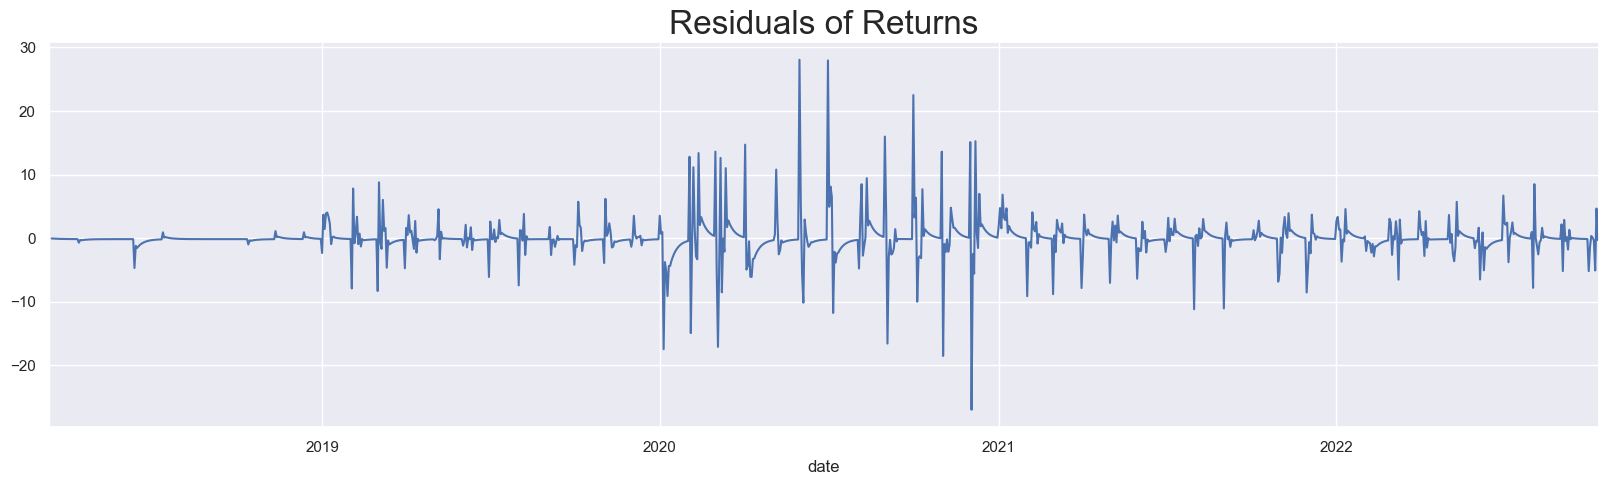

In [27]:
#Genera un gráfico que muestra los residuos del modelo ARMA(3,2) en un formato visual
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [28]:
#SEGÚN EL GRÁFICO

## La media de los residuos se desvía significativamente de cero, podría indicar que el modelo está sesgado.
## Notable dispersión de los residuos, al menos entre 2020 y 2021, lo que sugiere una heterocedasticidad.



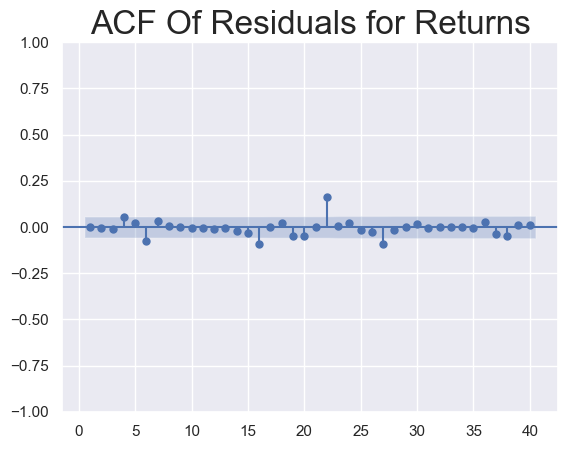

In [36]:
#Traza la función de autocorrelación (ACF) de los residuos del modelo ARMA(3,2) para análisis de series temporales
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

In [29]:
#SEGÚN EL GRÁFICO

## 4 barra son significativamente diferente de cero y se extiende más allá de la banda de confianza y 2 barras lo son levemente.
## Esto implica que los residuos en esos rezagos están correlacionados entre sí y no son completamente independientes.
## Por lo que, se considera ajustar el modelo para tener en cuenta esta autocorrelación o explorar modelos más complejos que manejen mejor esta estructura.

## Reevaluating Model Selection

In [30]:
# Especifico el modelo ARMA(5,5) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_5_ma_5
# Muestro un resumen de los resultados
model_ret_ar_5_ma_5 = ARIMA(df.returns[1:], order=(5, 0, 5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
results_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -3015.332
Date:                Fri, 13 Oct 2023   AIC                           6054.664
Time:                        21:07:19   BIC                           6115.725
Sample:                    03-13-2018   HQIC                          6077.667
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0558      0.030      1.881      0.060      -0.002       0.114
ar.L1         -0.4876      0.688     -0.709      0.478      -1.836       0.861
ar.L2          0.0662      0.589      0.112      0.911      -1.088       1.221
ar.L3          0.2649      0.366      0.724      0.469      -0.452       0.982
ar.L4          0.1997      0.254      0.788      0.431      -0.297       0.697
ar.L5         -0.0027      0.315     -0.009      0.993      -0.620       0.614
ma.L1          0.2605      0.688      0.378      0.705      -1.089       1.609
ma.L2         -0.4349      0.471     -0.923      0.356      -1.359       0.489
ma.L3         -0.5174      0.265     -1.954      0.051      -1.036       0.002
ma.L4         -0.1732      0.351     -0.494      0.622      -0.861       0.515
ma.L5          0.1446      0.466      0.310      0.757      -0.769       1.059
sigma2         8.9856      0.120     74.917      0.000       8.750       9.221
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             40001.35
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Especifico el modelo ARMA(5,1) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_5_ma_1
# Muestro un resumen de los resultados
model_ret_ar_5_ma_1 = ARIMA(df.returns[1:], order=(5,0,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
results_ret_ar_5_ma_1.summary()

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -3019.224
Date:                Fri, 13 Oct 2023   AIC                           6054.448
Time:                        21:07:24   BIC                           6095.155
Sample:                    03-13-2018   HQIC                          6069.783
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.030      1.888      0.059      -0.002       0.114
ar.L1          0.6554      0.034     19.076      0.000       0.588       0.723
ar.L2         -0.1075      0.021     -5.041      0.000      -0.149      -0.066
ar.L3          0.0101      0.019      0.526      0.599      -0.028       0.048
ar.L4          0.0809      0.021      3.927      0.000       0.041       0.121
ar.L5         -0.0262      0.029     -0.913      0.361      -0.082       0.030
ma.L1         -0.8860      0.031    -28.420      0.000      -0.947      -0.825
sigma2         9.0445      0.116     77.724      0.000       8.816       9.273
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39085.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Especifico el modelo ARMA(1,5) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_1_ma_5
# Muestro un resumen de los resultados
model_ret_ar_1_ma_5 = ARIMA(df.returns[1:], order=(1,0,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1198
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -3019.814
Date:                Fri, 13 Oct 2023   AIC                           6055.628
Time:                        21:07:28   BIC                           6096.336
Sample:                    03-13-2018   HQIC                          6070.964
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0552      0.037      1.510      0.131      -0.016       0.127
ar.L1         -0.7257      0.373     -1.946      0.052      -1.457       0.005
ma.L1          0.5029      0.373      1.348      0.178      -0.228       1.234
ma.L2         -0.4264      0.083     -5.163      0.000      -0.588      -0.265
ma.L3         -0.3555      0.100     -3.545      0.000      -0.552      -0.159
ma.L4         -0.1248      0.065     -1.914      0.056      -0.253       0.003
ma.L5          0.0317      0.030      1.049      0.294      -0.028       0.091
sigma2         9.0537      0.116     77.716      0.000       8.825       9.282
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39660.34
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(5,1) que fue ajustado previamente y cuyos resultados se guardarán en la variable results_ret_ar_5_ma_1.
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(1,5) que aparentemente también fue ajustado previamente y cuyos resultados se guardaron en la variable results_ret_ar_1_ma_5.
print("ARMA(5,1):  \t LL = ",results_ret_ar_5_ma_1.llf,"\t AIC = ",results_ret_ar_5_ma_1.aic)
print("ARMA(1,5):  \t LL = ",results_ret_ar_1_ma_5.llf,"\t AIC = ",results_ret_ar_1_ma_5.aic)

# En término de AIC, el modelo "ARMA(5,1)" tiene un AIC ligeramente más bajo (6054.4478) en comparación con el modelo "ARMA(1,5)" (6055.6285).
  #esto sugiere que el modelo "ARMA(5,1)" proporciona un ajuste ligeramente mejor a los datos en términos de AIC.

# En término de LL, el modelo "ARMA(5,1)" presenta un mejor ajuste del modelo a los datos, dado que -3019.8142 > -3019.2239.

ARMA(5,1):  	 LL =  -3019.2239153608634 	 AIC =  6054.447830721727
ARMA(1,5):  	 LL =  -3019.8142488673047 	 AIC =  6055.6284977346095


In [34]:
print("ARMA(3,2):  \t LL = ",results_ret_ar_3_ma_2.llf,"\t AIC = ",results_ret_ar_3_ma_2.aic)

# En término de LL, un valor de -3022.1631 indica que el modelo ARMA(3,2) se ajusta bien a los datos.

ARMA(3,2):  	 LL =  -3022.163098988897 	 AIC =  6058.326197977794


## Residuals for the New Model

In [35]:
# Agregar los residuos del modelo ARMA(5,1) al DataFrame df
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

C:\Users\Alexander Ciocca\AppData\Local\Temp\ipykernel_9616\1986335299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid


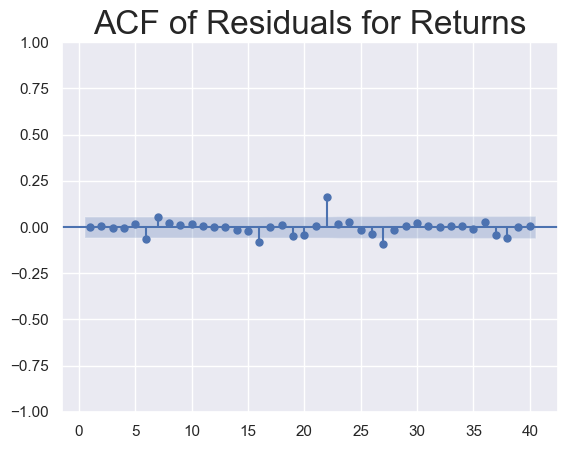

In [36]:
#Traza la función de autocorrelación (ACF) de los residuos del modelo ARMA(5,1) para análisis de series temporales
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns",size=24)
plt.show()

In [37]:
#SEGÚN EL GRÁFICO

## 4 barras son significativamente diferente de cero y se extiende más allá de la banda de confianza y 2 barras lo son levemente.
## Esto implica que los residuos en esos rezagos están correlacionados entre sí y no son completamente independientes.
## Por lo que, se considera ajustar el modelo para tener en cuenta esta autocorrelación o explorar modelos más complejos que manejen mejor esta estructura.

## ARMA Models for Prices

C:\Users\Alexander Ciocca\AppData\Local\Temp\ipykernel_9616\282977114.py:2: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  sgt.plot_acf(df.market_value, unbiased=True, zero = False, lags = 40)


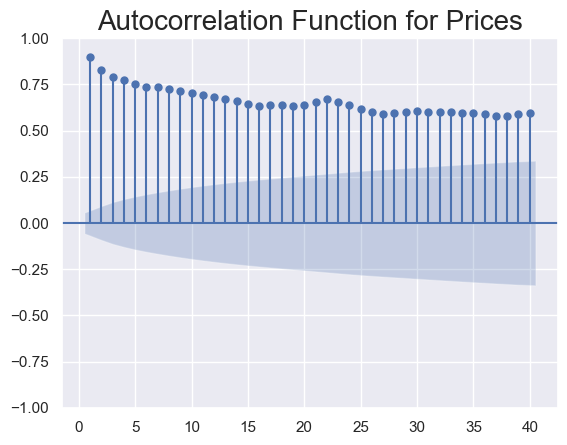

In [38]:
#Traza la función de autocorrelación (ACF) de la columna 'market_value' del DataFrame df, que parece contener datos de precios de mercado.
sgt.plot_acf(df.market_value, unbiased=True, zero = False, lags = 40)
plt.title("Autocorrelation Function for Prices",size=20)
plt.show()
#Este gráfico permite visualizar cómo los valores de la serie están correlacionados con sus propios valores en retrasos anteriores

In [39]:
#La ACF se utiliza para identificar componentes de media móvil (MA) en un modelo ARIMA.

#SEGÚN EL GRÁFICO

## Todas las barra se extiende más allá de la banda de confianza, lo que indica una correlación significativa en todos estos rezagos. 


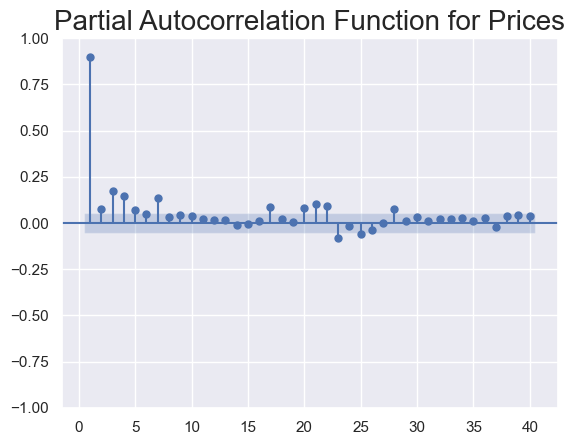

In [40]:
#Traza la función de autocorrelación parcial (PACF) de la columna 'market_value' del DataFrame df
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("Partial Autocorrelation Function for Prices",size=20)
plt.show()
# El gráfico muestra los valores de PACF en diferentes retrasos, lo que ayuda a identificar la estructura de dependencia temporal en los datos de precios de mercado

In [41]:
# Especifico el modelo ARMA(1,1) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_1_ma_1
# Muestro un resumen de los resultados
model_ar_1_ma_1 = ARIMA(df.market_value, order=(1,0,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8110.055
Date:                Fri, 13 Oct 2023   AIC                          16228.110
Time:                        21:07:53   BIC                          16248.467
Sample:                    03-12-2018   HQIC                         16235.779
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6953.5810     83.940     82.840      0.000    6789.061    7118.101
ar.L1          0.9266      0.012     76.920      0.000       0.903       0.950
ma.L1         -0.1468      0.015     -9.476      0.000      -0.177      -0.116
sigma2      4.386e+04    724.684     60.522      0.000    4.24e+04    4.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):             36456.01
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# Ahora, al agregar los residuos del modelo ARMA(1,1) al DataFrame df
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

C:\Users\Alexander Ciocca\AppData\Local\Temp\ipykernel_9616\3837356653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid


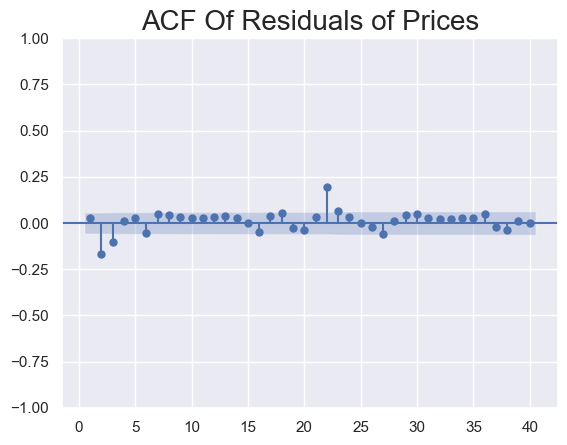

In [43]:
#Traza la función de autocorrelación (ACF) de los residuos del modelo ARMA(1,1) para análisis de series temporales
sgt.plot_acf(df.res_ar_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.show()

In [ ]:
#SEGÚN EL GRÁFICO

## 3 barras se extiende significativamente más allá de la banda de confianza, sugiere la presencia de autocorrelación serial en los residuos, lo que indica que el modelo podría necesitar mejoras.
## Este ajuste de agregar los residuos del modelo ARMA(1,1) al DataFrame df no impacta significativamente en la reducción de la presencia de autocorrelación.

In [44]:
# Especifico el modelo ARMA(6,6) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_6_ma_6
# Muestro un resumen de los resultados
model_ar_6_ma_6 = ARIMA(df.market_value, order=(6, 0, 6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_params=None)
results_ar_6_ma_6.summary()

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(6, 0, 6)   Log Likelihood               -8057.503
Date:                Fri, 13 Oct 2023   AIC                          16143.006
Time:                        21:08:23   BIC                          16214.256
Sample:                    03-12-2018   HQIC                         16169.847
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6953.5621    714.950      9.726      0.000    5552.285    8354.839
ar.L1          0.5644      0.075      7.514      0.000       0.417       0.712
ar.L2         -0.1166      0.103     -1.127      0.260      -0.319       0.086
ar.L3          0.2295      0.125      1.838      0.066      -0.015       0.474
ar.L4          0.0517      0.119      0.434      0.665      -0.182       0.286
ar.L5          0.7798      0.097      8.015      0.000       0.589       0.971
ar.L6         -0.5141      0.061     -8.426      0.000      -0.634      -0.394
ma.L1          0.2243      0.079      2.831      0.005       0.069       0.379
ma.L2          0.2328      0.063      3.706      0.000       0.110       0.356
ma.L3         -0.0242      0.081     -0.299      0.765      -0.182       0.134
ma.L4         -0.0283      0.070     -0.407      0.684      -0.165       0.108
ma.L5         -0.7933      0.063    -12.608      0.000      -0.917      -0.670
ma.L6         -0.1449      0.036     -4.012      0.000      -0.216      -0.074
sigma2      4.135e+04    807.955     51.173      0.000    3.98e+04    4.29e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):             36387.56
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Especifico el modelo ARMA(5,6) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_5_ma_6
# Muestro un resumen de los resultados
model_ar_5_ma_6 = ARIMA(df.market_value, order=(5,0,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit(start_params=None)
results_ar_5_ma_6.summary()

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(5, 0, 6)   Log Likelihood               -8062.120
Date:                Fri, 13 Oct 2023   AIC                          16150.239
Time:                        21:08:31   BIC                          16216.399
Sample:                    03-12-2018   HQIC                         16175.162
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6953.5629    229.159     30.344      0.000    6504.420    7402.706
ar.L1          0.4392      0.838      0.524      0.600      -1.202       2.081
ar.L2          0.2923      0.763      0.383      0.702      -1.204       1.788
ar.L3          0.3396      0.451      0.752      0.452      -0.545       1.224
ar.L4          0.1767      0.679      0.260      0.795      -1.154       1.507
ar.L5         -0.2614      0.475     -0.551      0.582      -1.191       0.669
ma.L1          0.3233      0.838      0.386      0.700      -1.319       1.965
ma.L2         -0.1164      0.352     -0.331      0.741      -0.806       0.573
ma.L3         -0.4154      0.355     -1.170      0.242      -1.111       0.280
ma.L4         -0.3998      0.661     -0.605      0.545      -1.695       0.895
ma.L5          0.0288      0.130      0.222      0.824      -0.225       0.283
ma.L6         -0.0238      0.118     -0.202      0.840      -0.255       0.207
sigma2      4.133e+04    719.564     57.436      0.000    3.99e+04    4.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36537.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Especifico el modelo ARMA(6,1) con ARIMA
# Ajusta un modelo ARMA a los datos y almacena los resultados en results_ret_ar_6_ma_1
# Muestro un resumen de los resultados
model_ar_6_ma_1 = ARIMA(df.market_value, order=(6,0,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit(start_params=None)
results_ar_6_ma_1.summary()

c:\Users\Alexander Ciocca\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 1199
Model:                 ARIMA(6, 0, 1)   Log Likelihood               -8064.623
Date:                Fri, 13 Oct 2023   AIC                          16147.246
Time:                        21:08:41   BIC                          16193.049
Sample:                    03-12-2018   HQIC                         16164.500
                         - 10-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6953.6235    276.485     25.150      0.000    6411.723    7495.524
ar.L1          1.6883      0.032     52.731      0.000       1.626       1.751
ar.L2         -0.7777      0.037    -20.820      0.000      -0.851      -0.705
ar.L3          0.1077      0.033      3.251      0.001       0.043       0.173
ar.L4          0.0416      0.033      1.267      0.205      -0.023       0.106
ar.L5         -0.0612      0.038     -1.614      0.107      -0.135       0.013
ar.L6         -0.0006      0.027     -0.023      0.982      -0.054       0.053
ma.L1         -0.9314      0.023    -41.121      0.000      -0.976      -0.887
sigma2      4.064e+04    674.786     60.232      0.000    3.93e+04     4.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             35497.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(5,6) que fue ajustado previamente y cuyos resultados se guardarán en la variable results_ret_ar_5_ma_6.
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(6,1) que aparentemente también fue ajustado previamente y cuyos resultados se guardaron en la variable results_ret_ar_6_ma_1.
print("ARMA(5,6):  \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(6,1):  \t LL = ", results_ar_6_ma_1.llf, "\t AIC = ", results_ar_6_ma_1.aic)

ARMA(5,6):  	 LL =  -8062.119535183307 	 AIC =  16150.239070366613
ARMA(6,1):  	 LL =  -8064.623004132879 	 AIC =  16147.246008265758


In [48]:
# El modelo ARMA(6,1) tiene un AIC ligeramente más bajo, lo que sugiere que proporciona un mejor ajuste a los datos con una estructura de modelo ligeramente más simple que el modelo ARMA(5,6).
# El modelo ARMA(6,1) tiene un LL más alto, lo que indica un mejor ajuste del modelo a los datos en comparación al modelo ARMA(5,6).

C:\Users\Alexander Ciocca\AppData\Local\Temp\ipykernel_9616\4162886236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid


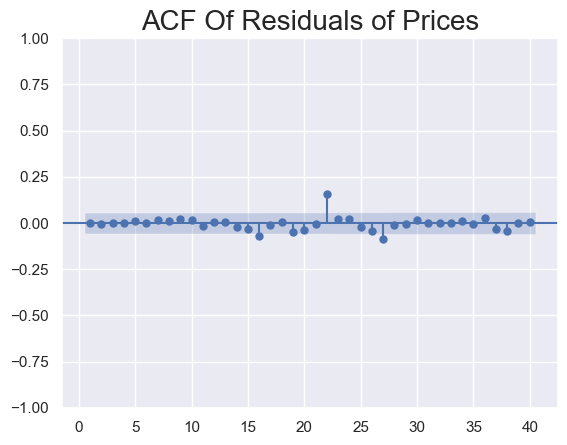

In [49]:
# Ahora, al agregar los residuos del modelo ARMA(5,6) al DataFrame df
df['res_ar_5_ma_6'] = results_ar_5_ma_6.resid
#Traza la función de autocorrelación (ACF) de los residuos del modelo ARMA(5,6) para análisis de series temporales
sgt.plot_acf(df.res_ar_5_ma_6, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.show()

In [50]:
##SEGÚN EL GRÁFICO

# 1 barras se e extiende significativamente más allá de la banda de confianza y 2 lo hacen levemente, esto sugiere la presencia de autocorrelación serial en los residuos, lo que indica que el modelo podría necesitar mejoras.

## ARMA for Returns vs ARMA for Prices

In [51]:
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(5,6) que fue ajustado previamente y cuyos resultados se guardarán en la variable results_ret_ar_5_ma_6.
#Función de verosimilitud logarítmica y el AIC para un modelo ARMA(5,1) que aparentemente también fue ajustado previamente y cuyos resultados se guardaron en la variable results_ret_ar_5_ma_1.
print("ARMA(5,6):  \t LL = ", results_ar_5_ma_6.llf, "\t AIC = ", results_ar_5_ma_6.aic)
print("ARMA(5,1):  \t LL = ", results_ret_ar_5_ma_1.llf, "\t AIC = ", results_ret_ar_5_ma_1.aic)

ARMA(5,6):  	 LL =  -8062.119535183307 	 AIC =  16150.239070366613
ARMA(5,1):  	 LL =  -3019.2239153608634 	 AIC =  6054.447830721727


In [ ]:
# El modelo ARMA(5,1) tiene un AIC más bajo, lo que sugiere que proporciona un mejor ajuste a los datos con una estructura de modelo ligeramente más simple que el modelo ARMA(5,6).
# El modelo ARMA(5,1) tiene un LL más alto, lo que indica un mejor ajuste del modelo a los datos en comparación al modelo ARMA(5,6).